# Exploratory data analysis of the mental health in tech industry

### Introduction:
In this analysis, we're diving deep into the mental health of people working in the tech industry over several years. We're looking at surveys from 2014, 2016, 2017, 2018, and 2019 to understand mental health differences across genders, age groups, types of jobs, and company cultures. Our goal is to figure out who might be more at risk for mental health issues and how different aspects of their work and workplace affect them.


### Results:
**Gender Disparities:** Across the years surveyed, we observed notable variations in mental health experiences between genders. Among women and people who don't identify themselves as either male or female, there is higher percent of people with mental health issues than among men. Moreover, men tend to seek for help with their mental issues less than other groups. Women have higher tendency towards eating disorder, post-traumatic stress disorder, men tend to have substance use disorder, personality disorder and stress response syndromes more. Among people who identify themselves outside of traditional binary gender, there is high percent of those with mood disorders.

**Age-Related Trends:** As individuals age, the prevalence of mood disorders tends to increase. In younger age groups, mood disorders, anxiety disorders, obsessive-compulsive disorders, and personality disorders are common. Addictive disorders, stress response syndromes, post-traumatic stress disorders are more prevalent in the age range of 25 to 45.

**Job Role Impacts:** Among designers, 55% of individuals have mental disorders, while the Human Resources field shows a 50/50 split between those with and without mental disorders. Top-level executives and supervisors/ team leads have the lowest prevalence of mental disorders. There's no difference in mental health between remote and office workers.

**Company Type Effects:** The availability of mental health coverage varies with company size, with smaller companies offering less coverage than larger corporations. Surprisingly, despite this difference, smaller companies have a higher percentage of healthy employees compared to larger ones. This suggests that company size may impact employee mental well-being, with smaller organizations potentially providing a healthier work environment. Larger companies prioritize physical health more than smaller ones. There's no clear trend in prioritizing mental health, though, the smallest companies show the highest emphasis. 

We start with importing the required modules:

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import helper_functions as hf

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['font.family'] = 'Arial'

In [3]:
conn = sqlite3.connect("mental_health.sqlite")
cursor = conn.cursor()

### First of all, let's explore the data we have:

In [4]:
sel_answer_q = ("SELECT * FROM Answer")
sel_survey_q = ("SELECT * FROM Survey")
sel_question_q = ("SELECT * FROM Question")

answers = pd.read_sql_query(sel_answer_q, conn)
surveys = pd.read_sql_query(sel_survey_q, conn)
questions = pd.read_sql_query(sel_question_q, conn)

Surveys table:

In [5]:
surveys

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


In [6]:
surveys.dtypes

SurveyID        int64
Description    object
dtype: object

Questions table:

In [7]:
questions

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


In [8]:
questions.dtypes

questiontext    object
questionid       int64
dtype: object

Answers table:

In [9]:
answers.head()

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


In [10]:
answers.shape

(236898, 4)

In [11]:
answers.dtypes

AnswerText    object
SurveyID       int64
UserID         int64
QuestionID     int64
dtype: object

After taking a quick glance at the provided data, we can conclude the following information about it.
* Surveys table:
    * SurverID - year of the survey(we have surveys from 2014 to 2019 years inclusive)
    * Description
* Questions table:
    * questionID
    * questionText
* Answers table:
    * AnswerText: answer the the question 
    * SurveyID(foreign key from surveys table)
    * QuestionID (foreign key from question table)
    * UserID 

### Our next step is to perform data cleaning

Question table:

In [12]:
# extract rows which have missing values in the question table
missing_questions_q = '''
                      SELECT * FROM question
                      WHERE questiontext IS NULL OR questionid is NULL
                      '''
pd.read_sql_query(missing_questions_q, conn)

,questiontext,questionid


We have no null values in the question table

In [13]:
# modify the questiontext column by lowering all the characters
# and getting rid of spaces
modify_questiontext_q = '''
                    UPDATE Question
                    SET questiontext = LOWER(TRIM(questiontext));
                    '''
cursor.execute(modify_questiontext_q)

In [14]:
questionid_check_q = '''
                SELECT MIN(questionid), MAX(questionid), 
                COUNT(DISTINCT questionid)
                FROM Question
                 '''
pd.read_sql_query(questionid_check_q, conn)

,MIN(questionid),MAX(questionid),COUNT(DISTINCT questionid)
0,1,118,105


Are there some misspelling questions?

In [15]:
questions_q = '''
                SELECT questiontext
                FROM Question
                ORDER BY 1;
                '''
list(pd.read_sql_query(questions_q, conn)["questiontext"])

['any additional notes or comments',
 'are you openly identified at work as a person with a mental health issue?',
 'are you self-employed?',
 'briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.',
 'describe the circumstances of the badly handled or unsupportive response.',
 'describe the circumstances of the supportive or well handled response.',
 'describe the conversation with coworkers you had about your mental health including their reactions.',
 'describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.',
 'describe the conversation you had with your previous coworkers about your mental health including their reactions.',
 'describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health

We have identified two dupllicates in the question column. Let's remove them.

In [16]:
question1 = ("describe the conversation "
            "your coworker had with you about "
            "their mental health (please do not use names)..1")

question2 = ("has your employer ever discussed mental "
            "health as part of an employee wellness program?")
# query to drop answers from duplicated columns
drop_answer_q = '''DELETE FROM Answer
                   WHERE questionid IN (
                                    SELECT questionid FROM Question
                                    WHERE questiontext IN (?, ?)
                                    )
            '''

# query to drop duplicated questions
drop_question_q = '''
                    DELETE FROM Question
                    WHERE questiontext IN 
                    (?, ?)
                  '''
cursor.execute(drop_answer_q, (question1, question2))
cursor.execute(drop_question_q, (question1, question2))

Answer table:

In [17]:
# extract unique SurveyId values
pd.read_sql_query("SELECT DISTINCT SurveyID FROM Answer", conn)

,SurveyID
0,2014
1,2016
2,2017
3,2018
4,2019


In [18]:
# query to check if all QuestionID in the Answer table
# exist in the Question table
questionid_check_q = '''
    SELECT QuestionID FROM Answer
    EXCEPT 
    SELECT questionid FROM Question
    '''
pd.read_sql_query(questionid_check_q, conn)

,QuestionID


In [19]:
# query to check the UserId column
userid_check_q = '''
                SELECT MIN(UserID), MAX(UserID), 
                COUNT(DISTINCT UserID)
                FROM Answer
                 '''
pd.read_sql_query(userid_check_q, conn)

,MIN(UserID),MAX(UserID),COUNT(DISTINCT UserID)
0,1,4218,4218


We have performed data cleaning of the provided tables, identified some misspelling names and modified them. 

### Now, let's try to understand more what information the data provides

Are the surveyed people the same throughout the years?

In [20]:
common_users_q = """
             SELECT UserID
             FROM Answer
             WHERE SurveyID = 2014
             INTERSECT
             SELECT UserID
             FROM Answer
             WHERE SurveyID = 2016
             INTERSECT
             SELECT UserID
             FROM Answer
             WHERE SurveyID = 2017
             INTERSECT
             SELECT UserID
             FROM Answer
             WHERE SurveyID = 2018
             INTERSECT
             SELECT UserID
             FROM Answer
             WHERE SurveyID = 2019
            """
pd.read_sql_query(common_users_q, conn)

,UserID


In each year, different users were surveyed

How many users were in each survey year?

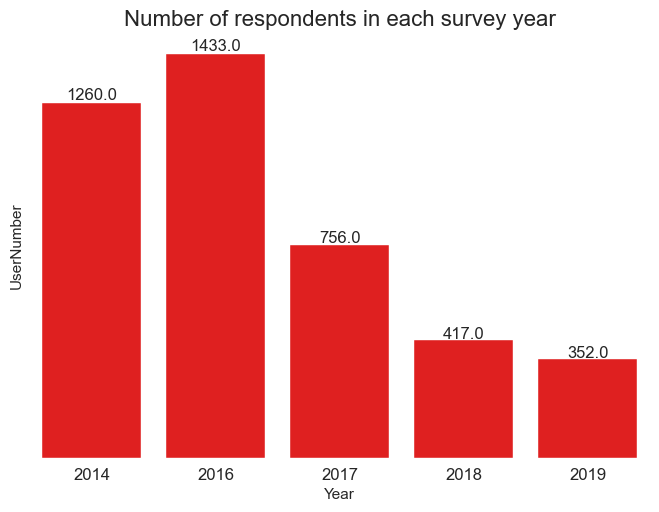

In [21]:
# query to count users in each survey year
yearusers_count_q = """
                        SELECT SurveyID Year, COUNT(DISTINCT UserID) UserNumber
                        FROM Answer
                        GROUP BY 1
                        ORDER BY 1;
                        """
year_users = pd.read_sql_query(yearusers_count_q, conn)
sns.barplot(x="Year", y="UserNumber", data=year_users, color="red")
hf.customize_bar("v", plt.gca())
plt.title("Number of respondents in each survey year", fontsize=16);

The number of surveyed people has been decreasing since 2016

Where the same question asked in each survey year?

In [22]:
common_questions_q = """
            SELECT q.questiontext
            FROM
             (SELECT QuestionID
             FROM Answer
             WHERE SurveyID = 2014
             INTERSECT
             SELECT QuestionID
             FROM Answer
             WHERE SurveyID = 2016
             INTERSECT
             SELECT QuestionID
             FROM Answer
             WHERE SurveyID = 2017
             INTERSECT
             SELECT QuestionID
             FROM Answer
             WHERE SurveyID = 2018
             INTERSECT
             SELECT QuestionID
             FROM Answer
             WHERE SurveyID = 2019) common_questions
            JOIN Question q ON q.questionid = common_questions.QuestionID
             
            """
common_questions = pd.read_sql_query(common_questions_q, conn)
common_questions

,questiontext
0,what is your age?
1,what is your gender?
2,what country do you live in?
3,"if you live in the united states, which state ..."
4,are you self-employed?
5,do you have a family history of mental illness?
6,have you ever sought treatment for a mental he...
7,how many employees does your company or organi...
8,is your employer primarily a tech company/orga...
9,does your employer provide mental health benef...


Only these 12 questions were asked in each survey

Are there questions with multiple answers from the same users?

In [23]:
# extract questions which have two or more
# answer from the same user
duplicated_answers_q = """
                        SELECT DISTINCT q.QuestionText
                        FROM Answer a
                        JOIN Question q ON q.questionid = a.QuestionID
                        GROUP BY a.SurveyID, a.UserID, a.QuestionID
                        HAVING COUNT(*) > 1
                        ORDER BY UserID
                       """
pd.read_sql_query(duplicated_answers_q, conn)

,questiontext
0,"if yes, what condition(s) have you been diagno..."
1,which of the following best describes your wor...
2,"if maybe, what condition(s) do you believe you..."


These are the questions that have multiple answers from the same users

How many questions were asked in each year?

In [24]:
# count distinct questions in each year
yearquestions_count_q = """
                        SELECT SurveyID Year, 
                        COUNT(DISTINCT QuestionID) QuestionNumber
                        FROM Answer
                        GROUP BY 1
                        ORDER BY 1;
                        """
year_questions = pd.read_sql_query(yearquestions_count_q, conn)

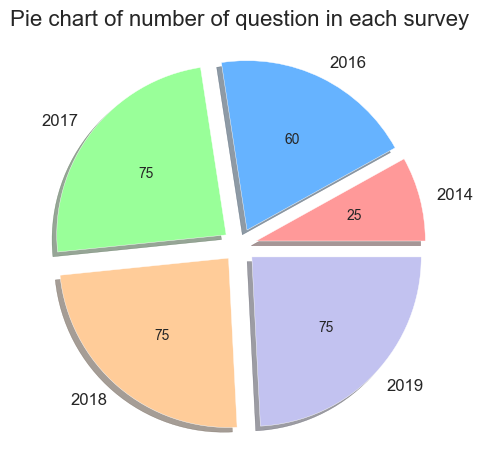

In [25]:
# calculate total number of questions
total_questions = year_questions["QuestionNumber"].sum()
plt.pie(year_questions["QuestionNumber"], labels=year_questions["Year"],
        autopct=lambda x: f"{round(total_questions*x/100)}",
       shadow=True, explode=(0.1, 0.1, 0.1, 0.1, 0.1), 
        colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'])
plt.title("Pie chart of number of question in each survey", fontsize=16);

In the first year(2014), there were the least number of question, while in the last 3 years, there were 75 questions in each survey

Were the questions the same in the last 3 years?

In [26]:
common_users_q = """
            SELECT q.questiontext
            FROM
             (
             SELECT QuestionID
             FROM Answer
             WHERE SurveyID = 2017
             INTERSECT
             SELECT QuestionID
             FROM Answer
             WHERE SurveyID = 2018
             INTERSECT
             SELECT QuestionID
             FROM Answer
             WHERE SurveyID = 2019) common_questions
            JOIN Question q ON q.questionid = common_questions.QuestionID
             
            """
pd.read_sql_query(common_users_q, conn)

,questiontext
0,what is your age?
1,what is your gender?
2,what country do you live in?
3,"if you live in the united states, which state ..."
4,are you self-employed?
...,...
70,"overall, how well do you think the tech indust..."
71,briefly describe what you think the industry a...
72,if there is anything else you would like to te...
73,would you be willing to talk to one of us more...


The last 3 surveys were the same

**After analyzing our tables, let's find who our surveyed participants are**:
   * What is their age?
   * What is their gender?
   * Where do they live?
   * What type of work they do?
   * What type of company they work in?

In [27]:
# modify the AnswerText column by lowering the letters
# and getting rid of the spaces
modify_answertext_q = '''
                    UPDATE Answer
                    SET AnswerText = LOWER(TRIM(AnswerText));
                    '''
cursor.execute(modify_answertext_q)

What is respondents' age?

In [28]:
# extract answers to the question about age
age_query = """
            SELECT AnswerText, UserID
            FROM Answer
            WHERE questionid = 1;
            """
age_question = pd.read_sql_query(age_query, conn)

# convert AnswerText to int type
age_question["AnswerText"] = age_question["AnswerText"].astype(int)

In [29]:
age_question["AnswerText"].describe()

count    4218.000000
mean       33.915363
std        10.478054
min       -29.000000
25%        28.000000
50%        33.000000
75%        38.000000
max       329.000000
Name: AnswerText, dtype: float64

We notice some outliers in the age feature. Let's explore them

In [30]:
# extract answers where the age < 18 or > 100
outlier_age_q = '''
                SELECT AnswerText, UserID
                FROM Answer
                WHERE QuestionID = 1 AND
                (CAST(AnswerText AS INTEGER) < 18 
                OR CAST(AnswerText AS INTEGER) > 100)
                '''
pd.read_sql_query(outlier_age_q, conn)

,AnswerText,UserID
0,-29,144
1,329,365
2,-1,391
3,-1,716
4,5,735
5,8,990
6,11,1091
7,-1,1128
8,17,1354
9,323,1825


Drop ages that are < 15 and > 100.

In [31]:
drop_age_outliers_q = '''DELETE FROM Answer
                         WHERE QuestionID = 1 
                         AND AnswerText 
                         IN ('-29', '-1', '0', '323',
                         '329', '3', '11', '8', '5');
                      '''
cursor.execute(drop_age_outliers_q)

Text(0.5, 0, 'Age')

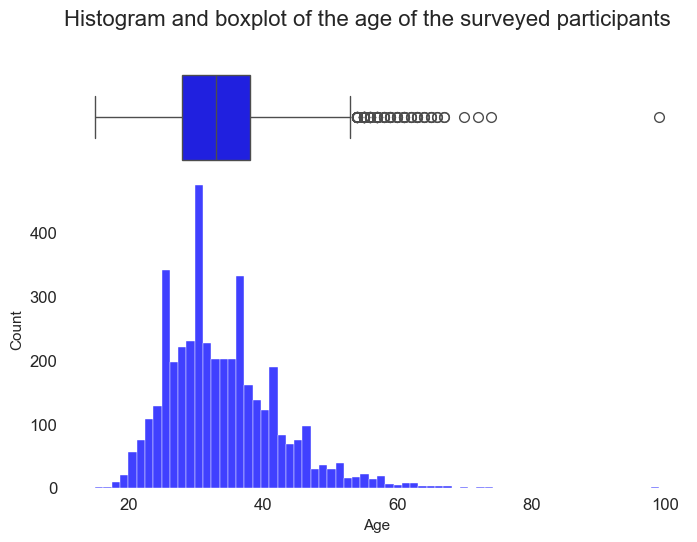

In [32]:
# extract age column again
age_question = pd.read_sql_query(age_query, conn)
age_question["AnswerText"] = age_question["AnswerText"].astype(int)
hf.hist_box(age_question, "AnswerText")
plt.suptitle("Histogram and boxplot of the age of the surveyed participants",
            fontsize=16)
plt.xlabel("Age")

The age distribution of our respondents is skewed to the right. However, we've noticed anomalies where some respondents report ages close to 100 or below 18. Almost all respondents fall within the age range of 20 to 60 years old.

Furthermore, the Interquartile Range (IQR), which represents the middle 50% of the data, spans approximately from 30 to 40 years old

**Let's examine gender characteristic of our respondents:**

In [33]:
gender_distinct_q = '''
                    SELECT DISTINCT AnswerText
                    FROM Answer
                    WHERE questionID = 2;
                    '''
list(pd.read_sql_query(gender_distinct_q, conn)["AnswerText"])

['female',
 'male',
 'male-ish',
 'trans-female',
 'something kinda male?',
 'queer/she/they',
 'non-binary',
 'nah',
 'all',
 'enby',
 'fluid',
 'genderqueer',
 'androgyne',
 'agender',
 'guy (-ish) ^_^',
 'male leaning androgynous',
 'trans woman',
 'neuter',
 'female (trans)',
 'queer',
 'a little about you',
 'p',
 'ostensibly male, unsure what that really means',
 'bigender',
 'female assigned at birth',
 'fm',
 'transitioned, m2f',
 'genderfluid (born female)',
 'other/transfeminine',
 'female or multi-gender femme',
 'androgynous',
 'male 9:1 female, roughly',
 '-1',
 'other',
 'nb masculine',
 'none of your business',
 'human',
 'genderfluid',
 'genderqueer woman',
 'mtf',
 'male/genderqueer',
 'nonbinary',
 'unicorn',
 'male (trans, ftm)',
 'genderflux demi-girl',
 'female-bodied; no feelings about gender',
 'afab',
 'transgender woman',
 'male/androgynous',
 'uhhhhhhhhh fem genderqueer?',
 'god king of the valajar',
 'agender/genderfluid',
 'sometimes',
 'woman-identified',
 

There were a lot of different answers about gender. Let's drop the answers that don't make sense

In [34]:
# create a tuple of the answers that have to be deleted
weird_answers = ("rr", "43", "masculino", "i am a wookie",
                 "femmina", "questioning",
                 "swm", "she/her/they/them", "none", "-1", "\\-",
                 "sometimes", "god king of the valajar", 
                 "uhhhhhhhhh fem genderqueer?", "afab", 
                 "unicorn", "a little about you", "p", "guy (-ish) ^_^",
                 "all", "nah", "something kinda male?", 
                 "ostensibly male, unsure what that really means",
                 "none of your business", "human")

# create a list of placeholders to put into a query
placeholders = ", ".join("?" * len(weird_answers))
delete_missing_q = '''DELETE FROM Answer
                    WHERE questionID = 2
                    AND AnswerText IN ({})'''.format(placeholders)
cursor.execute(delete_missing_q, weird_answers)

Let's keep only the following groups: male, female and all the other values will be in the other group(those who don't identify as either male or female)

In [35]:
# replace all of the gender answers to "other" value
update_gender_q = '''
                    UPDATE Answer
                    SET AnswerText = 'other'
                    WHERE questionID = 2 
                    AND AnswerText NOT IN ('male', 'female');
                    '''
cursor.execute(update_gender_q)

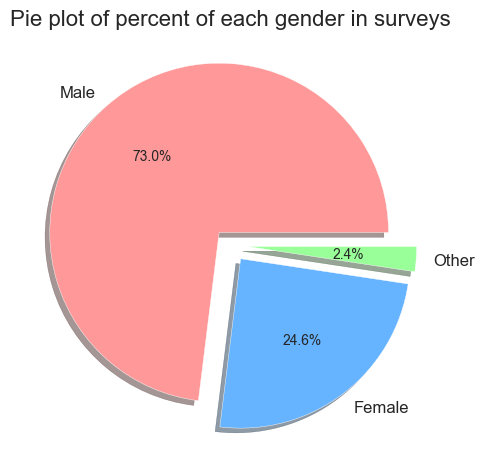

In [36]:
# count gender of the respondents
gender_count_q = '''
                SELECT AnswerText, COUNT(*) gendercount
                FROM Answer
                WHERE questionID = 2
                GROUP BY 1
                ORDER BY 2 DESC;
               '''
gender_count = pd.read_sql_query(gender_count_q, conn)
plt.pie(gender_count["gendercount"], labels=["Male", "Female", "Other"],
        autopct='%1.1f%%', colors=['#ff9999', '#66b3ff', '#99ff99'], 
        explode=(0.1, 0.1, 0.1), shadow=True)
plt.title("Pie plot of percent of each gender in surveys", fontsize=16);

It has to be pointed out that majority of the respondents are male(73%), while females are 24.6% of all surveyed people. In addition, there is a minority of people(2.4%) who don't identify themselves as male or female

**Where do our respondents live?**

In [37]:
# extract answers to the question:
# "Where do you live?"
country_distinct_q = '''
                    SELECT DISTINCT AnswerText
                    FROM Answer
                    WHERE questionID = 3;
                    '''
# display a sorted list of all answers
sorted(pd.read_sql_query(country_distinct_q, conn)["AnswerText"])

['-1',
 'afghanistan',
 'algeria',
 'argentina',
 'australia',
 'austria',
 'bahamas, the',
 'bangladesh',
 'belarus',
 'belgium',
 'bosnia and herzegovina',
 'brazil',
 'brunei',
 'bulgaria',
 'canada',
 'chile',
 'china',
 'colombia',
 'costa rica',
 'croatia',
 'czech republic',
 'denmark',
 'ecuador',
 'estonia',
 'ethiopia',
 'finland',
 'france',
 'georgia',
 'germany',
 'ghana',
 'greece',
 'guatemala',
 'hong kong',
 'hungary',
 'iceland',
 'india',
 'indonesia',
 'iran',
 'ireland',
 'israel',
 'italy',
 'japan',
 'jordan',
 'kenya',
 'latvia',
 'lithuania',
 'macedonia',
 'mauritius',
 'mexico',
 'moldova',
 'netherlands',
 'new zealand',
 'nigeria',
 'norway',
 'other',
 'pakistan',
 'philippines',
 'poland',
 'portugal',
 'romania',
 'russia',
 'saudi arabia',
 'serbia',
 'singapore',
 'slovakia',
 'slovenia',
 'south africa',
 'spain',
 'sweden',
 'switzerland',
 'taiwan',
 'thailand',
 'turkey',
 'ukraine',
 'united kingdom',
 'united states',
 'united states of america',

We noticed misspelling name in the USA. Let's fix it

In [38]:
update_country_q = '''
                    UPDATE Answer
                    SET AnswerText = 'united states'
                    WHERE questionID = 3 
                    AND AnswerText = 'united states of america';
                    '''
cursor.execute(update_country_q)

The surveyed participants live in 80 different counties


/var/folders/pl/3kzc8xg569bgwf57z74fn11w0000gn/T/ipykernel_40321/3639383527.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


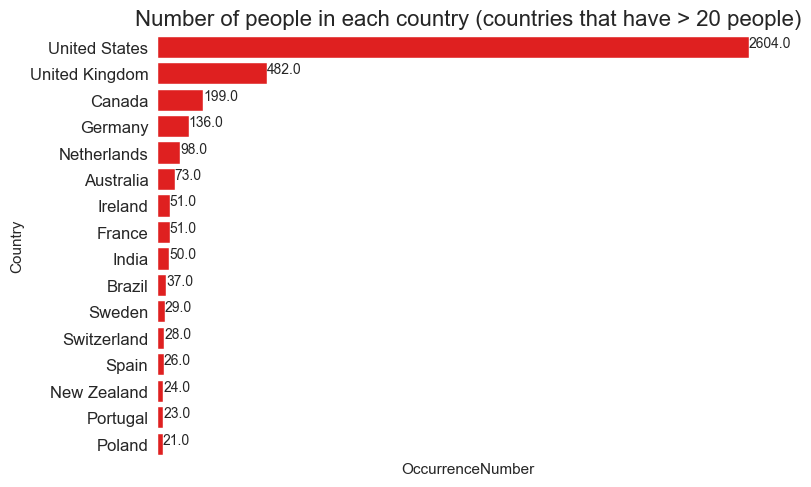

In [ ]:
# count number of countries
country_count_q = '''
                    SELECT AnswerText Country, COUNT(*) OccurrenceNumber
                    FROM Answer
                    WHERE questionID = 3
                    GROUP BY 1
                    ORDER BY 2 DESC;
                    '''
country_count = pd.read_sql_query(country_count_q, conn)
print(f"The surveyed participants live in {len(country_count)} "
     "different counties")
sns.barplot(y="Country", x="OccurrenceNumber",
            data=country_count[country_count["OccurrenceNumber"] > 20],
           color="red")
ax = plt.gca()
hf.customize_bar("h", ax, values_font=10)
ax.set_yticklabels(
    [label.get_text().title() for label in ax.get_yticklabels()]
)

plt.title("Number of people in each country"
          " (countries that have > 20 people)", fontsize=16);


We see that majority of the surveyed people are from the United States of America. The survey includes people from 80 countries. However, majority of counties are represented by a small number of people. Countries with the most number of respondents tend to be more developed, popular and populated.

States of the USA where people live

In [40]:
# extract answers to the question:
# If you live in the USA, what state do you live in?
state_distinct_q = '''
                    SELECT DISTINCT AnswerText
                    FROM Answer
                    WHERE questionID = 4;
                    '''
sorted(pd.read_sql_query(state_distinct_q, conn)["AnswerText"])

['-1',
 'alabama',
 'alaska',
 'arizona',
 'california',
 'colorado',
 'connecticut',
 'dc',
 'delaware',
 'district of columbia',
 'florida',
 'georgia',
 'idaho',
 'illinois',
 'indiana',
 'iowa',
 'kansas',
 'kentucky',
 'louisiana',
 'maine',
 'maryland',
 'massachusetts',
 'michigan',
 'minnesota',
 'mississippi',
 'missouri',
 'montana',
 'nebraska',
 'nevada',
 'new hampshire',
 'new jersey',
 'new mexico',
 'new york',
 'north carolina',
 'north dakota',
 'ohio',
 'oklahoma',
 'oregon',
 'pennsylvania',
 'rhode island',
 'south carolina',
 'south dakota',
 'tennessee',
 'texas',
 'utah',
 'vermont',
 'virginia',
 'washington',
 'west virginia',
 'wisconsin',
 'wyoming']

Fix misspelling name in the District of Columbia

In [41]:
update_state_q = '''
                    UPDATE Answer
                    SET AnswerText = 'district of columbia'
                    WHERE questionID = 4 AND AnswerText = 'dc';
                    '''
cursor.execute(update_country_q)

/var/folders/pl/3kzc8xg569bgwf57z74fn11w0000gn/T/ipykernel_40321/266430464.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


Text(0, 0.5, '')

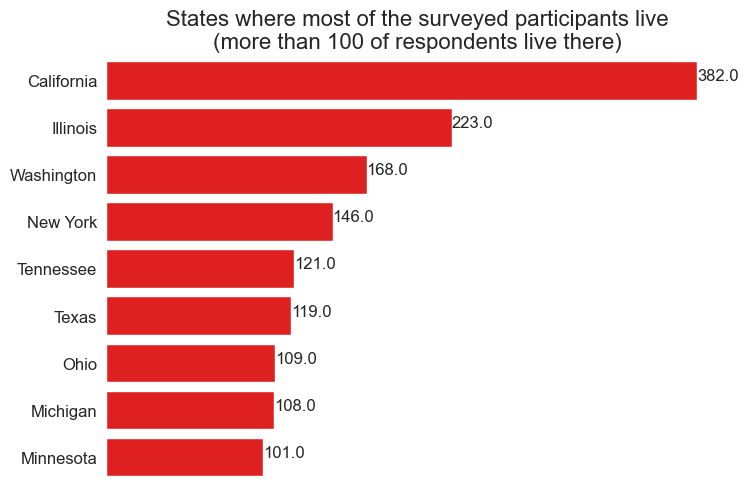

In [42]:
# count number of occurrences of each state
state_distinct_q = '''
                    SELECT AnswerText State, COUNT(*) OccurrenceNumber
                    FROM Answer
                    WHERE questionID = 4 AND AnswerText <> '-1'
                    GROUP BY 1
                    ORDER BY 2 DESC;
                    '''
state_distinct = pd.read_sql_query(state_distinct_q, conn)

sns.barplot(x="OccurrenceNumber", y="State",
           data=state_distinct[state_distinct["OccurrenceNumber"] > 100],
           color="red")
plt.title("States where most of the surveyed participants live\n"
          "(more than 100 of respondents live there)", fontsize=16)
ax = plt.gca()
ax.set_yticklabels(
    [label.get_text().title() for label in ax.get_yticklabels()]
)

hf.customize_bar("h", ax)
plt.xlabel("")
plt.ylabel("")

Here we see the list of most popular states of respondents. California is the leader here

**Do the surveyed people have IT related roles and work in IT companies?**

In [43]:
# extract the answer to the question:
# "do you have a Tech/It related role in your company?"
it_role_q = '''
            SELECT AnswerText, COUNT(*) count
            FROM Answer
            WHERE QuestionID = 13
            AND AnswerText != '-1'
            GROUP BY 1
            '''
it_role = pd.read_sql_query(it_role_q, conn)

# extract the answer to the question:
# "is your employer a Tech company/organization"
tech_company_q = '''
            SELECT AnswerText ITcompany, COUNT(*) count
            FROM Answer
            WHERE QuestionID = 9
            AND AnswerText != '-1'
            GROUP BY 1
            '''
tech_company = pd.read_sql_query(tech_company_q, conn)

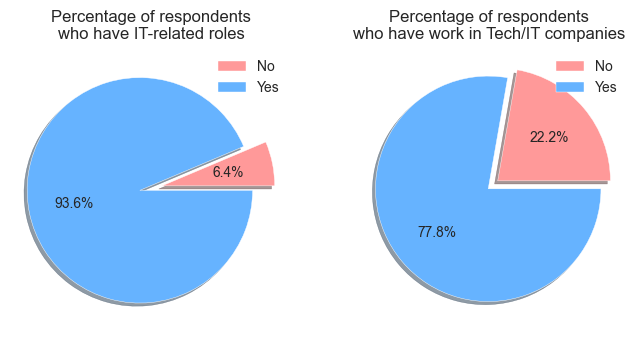

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(8, 12))

ax[0].pie(it_role["count"], 
        autopct="%1.1f%%", colors=['#ff9999', '#66b3ff'],
         shadow=True, explode=(0.1, 0.1))
ax[0].set_title("Percentage of respondents\n"
                "who have IT-related roles")
ax[0].legend(["No", "Yes"], loc="best")
ax[1].pie(tech_company["count"], 
        autopct="%1.1f%%", colors=['#ff9999', '#66b3ff'], 
          shadow=True, explode=(0.1, 0.01))
ax[1].set_title("Percentage of respondents\n"
                "who have work in Tech/IT companies")
ax[1].legend(["No", "Yes"], loc="upper right");

Majority of the respondents have Teck/IT roles at their companies and almost 80% of the surveyed participants work in Tech/IT company

**After analysing our respondents, we can conclude the following things:**
   * Most survey participants fall within the age range of 20 to 60, with a few outliers aged 15 or nearing 100
   * The survey primarily comprises men. Likewise, we have a small minority (approximately 3%) identifying outside the male-female binary. 
   * Respondents reside in 80 distinct counties, though the majority are from the USA, particularly California. Most counties are represented by only one person. 
   * nearly 94% of respondents hold Tech/IT positions within their companies and around 78% work in Tech/IT related company.

**Now, that we know the data provided and who are the surveyed people, let's try to understand their mental health.**
We will try to answer the following questions:
   * How has the percentage of individuals with mental disorders evolved over the years?
   * Regarding gender, which group shows a higher susceptibility to mental disorders?
   * Among different genders, who tends to seek help more and be more open about discussing mental health?
   * What are the most common mental disorders reported by survey participants?
   * Are certain disorders more prevalent among one gender compared to others?
   * Do individuals diagnosed with various disorders have a family history of mental illness?
   * Does the prevalence of mental disorders increase with age?
   * How do mental characteristics vary among individuals in different job roles?
   * Does remote work impact individuals' mental well-being and contribute to an increase in mental health issues?
   * Are there differences in the types of mental health issues experienced by individuals who work remotely compared to those who do not?
   * Regarding employment status, is there a distinction in mental health between those who are self-employed and those who are not?
   * Are there particular conditions that are more common among self-employed individuals?
   * What is the distribution of our respondents across different sizes of companies?
   * Among different company sizes, which ones offer mental health benefits as part of their healthcare coverage?
   * How does the percentage of individuals with mental health disorders vary across different company sizes?
   * Among companies of varying sizes, who prioritizes both physical and mental health?

**How has the percentage of individuals with mental disorders evolved over the years?**

In [45]:
# extract answers to the question:
# "Do you currently have a mental health disorder?"
have_mental_disorder_q = '''
                        SELECT AnswerText, SurveyID
                        FROM Answer
                        WHERE QuestionID IN (33)
                        '''
pd.read_sql_query(have_mental_disorder_q, conn)["AnswerText"].unique()

array(['no', 'yes', 'maybe', 'possibly', "don't know"], dtype=object)

Replace 'maybe' with 'possibly' as these answers are the same

In [46]:
modify_disorder_answ_q = '''
                        UPDATE Answer
                        SET AnswerText = 'possibly'
                        WHERE QuestionID IN (33) AND AnswerText = 'maybe'
                        '''
cursor.execute(modify_disorder_answ_q)

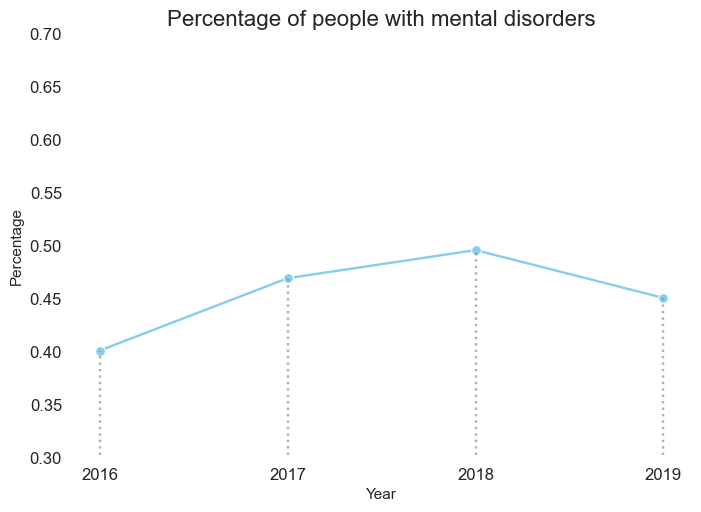

In [48]:
# for each year, calculate the percent with, without and 
# possibly with disorders
year_answer_q = '''
                SELECT SurveyID Year, AnswerText HaveDisorder, 
                CAST(COUNT(*) AS FLOAT) / total pct
                FROM Answer a1
                JOIN (
                    SELECT SurveyID Year, COUNT(*) total
                    FROM Answer 
                    WHERE QuestionID = 33
                    AND AnswerText NOT IN ('-1', "don't know")
                    GROUP BY 1) a2 ON a2.Year = a1.SurveyID
                WHERE QuestionID = 33
                AND AnswerText NOT IN ('-1', "don't know")
                GROUP BY 1,2
                '''
year_answer = pd.read_sql_query(year_answer_q, conn)
# keep only values with disorders
year_answer = year_answer[year_answer["HaveDisorder"] == 'yes']

# convert "Year" to str column for plotting
year_answer['Year'] = year_answer['Year'].astype(str)
sns.lineplot(x="Year", y="pct", data=year_answer, 
             marker='o', color='skyblue')
for x, y in zip(year_answer['Year'], year_answer["pct"]):
    plt.vlines(x, ymin=0, ymax=y, colors='gray', 
               linestyles='dotted', alpha=0.6)
plt.ylim(0.3, 0.7)
plt.ylabel("Percentage")
plt.title("Percentage of people with mental disorders",
         fontsize=16);

Over the years, we've observed a subtle shift in the prevalence of mental disorders. From 2016 to 2018, there was an increase in the percentage of people affected by mental disorders, coinciding with a decrease in the percentage of individuals without such disorders. However, in 2019, an interesting reversal occurred, with the trend showing a slight decrease in the proportion of individuals with mental disorders. 

**Regarding gender, which group shows a higher susceptibility to mental disorders?**

In [49]:
# extract answers to questions 
# "What is your gender? and 
# "Have you ever been diagnosed with a mental disorder"
gender_disorder_q = '''
    SELECT a1.AnswerText Gender, Disorder
    FROM Answer a1
    JOIN (SELECT AnswerText Disorder, UserID
          FROM Answer WHERE questionID = 34
          AND AnswerText NOT IN ('-1', "don't know")) 
          a2 ON a2.UserID = a1.UserID
    WHERE a1.questionID = 2
    '''
gender_disorder = pd.read_sql_query(gender_disorder_q, conn)

# check for possible values in the answer about a disorder
gender_disorder["Disorder"].unique()

array(['yes', 'no'], dtype=object)

In [50]:
# count number of answers to a question
# regarding a disorder for each gender
gender_disorder_count_q = '''
    SELECT a1.AnswerText Gender, Disorder, COUNT(*) count
    FROM Answer a1
    JOIN (SELECT AnswerText Disorder, UserID
          FROM Answer WHERE questionID = 34
          AND AnswerText <> "-1") a2 ON a2.UserID = a1.UserID
    WHERE a1.questionID = 2
    GROUP BY 1,2
    '''
gender_disorder_count = pd.read_sql_query(gender_disorder_count_q, conn)

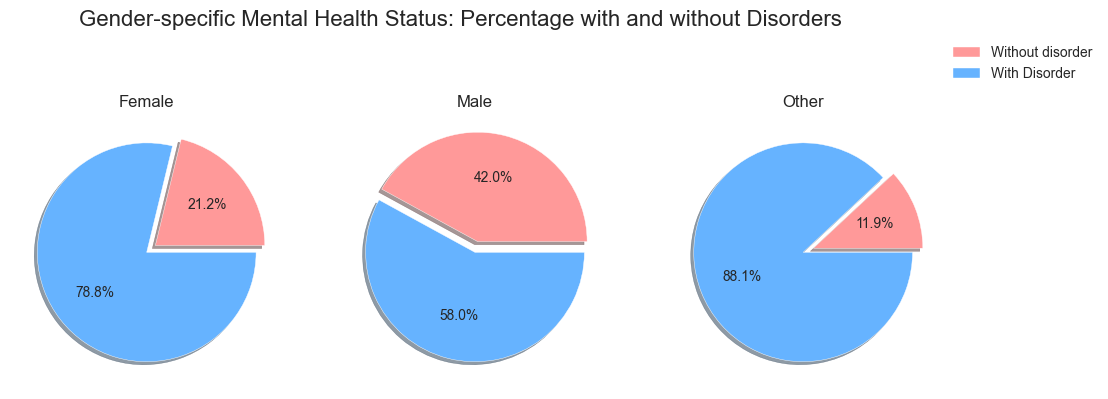

In [51]:
# extract gender values
unique_genders = gender_disorder_count["Gender"].unique()

# Create a new figure
plt.figure(figsize=(12, 5))  # Adjust the figsize as needed

# Iterate over unique genders and plot pie charts
for i, gender in enumerate(unique_genders, 1):
    plt.subplot(1, len(unique_genders), i)
    
    group = gender_disorder_count[gender_disorder_count["Gender"] == gender]
    plt.pie(group["count"], autopct='%1.1f%%',
           colors=['#ff9999', '#66b3ff'], shadow=True, explode=(0.1, 0.001))
    plt.title(gender.capitalize())
    
    
plt.legend(["Without disorder", "With Disorder"], 
           loc="upper left", bbox_to_anchor=(1, 1.3))
    

plt.suptitle("Gender-specific Mental Health Status:"
             " Percentage with and without Disorders", fontsize=16);

Upon examining the pie charts, we can conclude that among our respondents there are a lot of people with mental disorders. It's evident that there's a significantly higher proportion of females and individuals who identify outside the binary genders who have reported being diagnosed with a mental health disorder. Among males, although the percentage is also notable, it is lower compared to the other groups.

**Among different genders, who tends to seek help more and be more open about discussing mental health?**

In [52]:
# check for possible answers in the question:
# "Are you willing to share your mental issue with your family"
share_q = '''SELECT AnswerText Share, UserID
       FROM Answer WHERE questionID = 30'''
pd.read_sql_query(share_q, conn)["Share"].unique()

array(['somewhat open', 'neutral',
       'not applicable to me (i do not have a mental illness)',
       'very open', 'not open at all', 'somewhat not open'], dtype=object)

In [53]:
# drop answer: not applicable to me
share_q = '''DELETE FROM Answer
            WHERE questionID = 30 AND
            AnswerText = 
            "not applicable to me (i do not have a mental illness)"
            '''
cursor.execute(share_q)

In [54]:
# check for possible answers in the question:
# Have you ever sought for treatment?
sought_treatment_q = '''SELECT AnswerText SoughtTreatment, UserID
                        FROM Answer WHERE questionID = 7'''
pd.read_sql_query(sought_treatment_q, conn)["SoughtTreatment"].unique()

array(['1', '0'], dtype=object)

Plot two heatmaps:
    1. Percent of people in each gender group who have sought treatment
    2. Percent of people in each gender group and how open they are to talk with their family about the problem

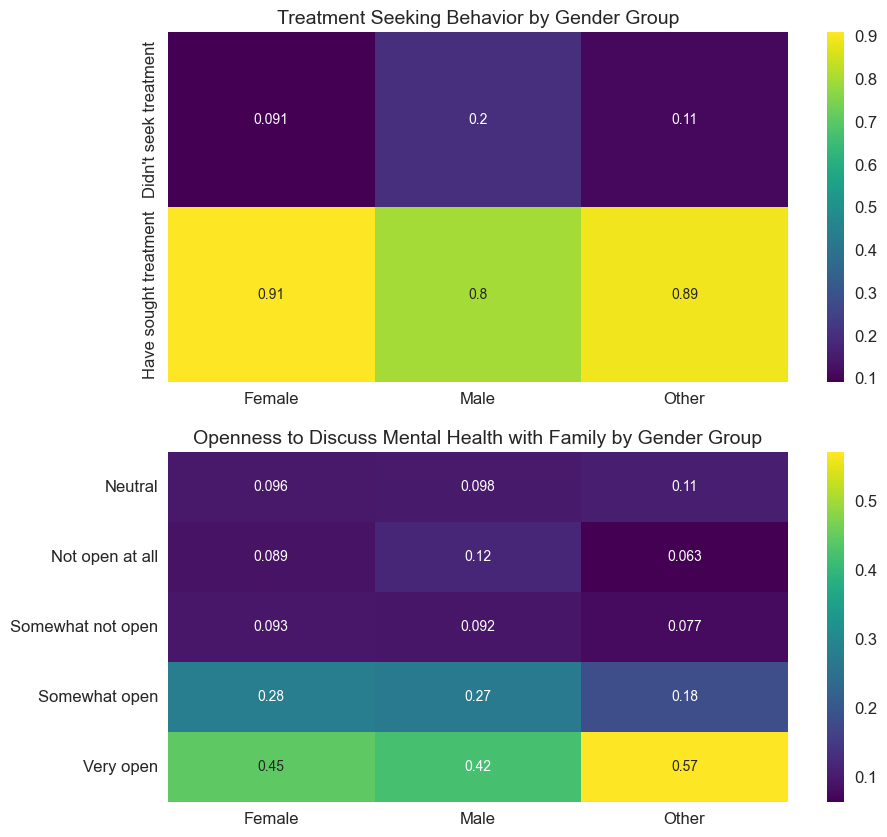

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.2)
for i, question_id in enumerate([7, 30]):
    # count number of people in each gender for a question_id
    count_q = '''
                SELECT a1.AnswerText Gender, 
                QuestionAnswer, COUNT(*) count
                FROM Answer a1
                JOIN (SELECT AnswerText QuestionAnswer, UserID
                      FROM Answer WHERE questionID =  ?) 
                      a2 ON a2.UserID = a1.UserID
                JOIN (SELECT AnswerText HaveDisorder, UserID
                      FROM Answer WHERE questionID IN (32, 33)
                      AND AnswerText = 'yes' OR AnswerText = 'possibly') 
                      a3 ON a3.UserID = a1.UserID
                WHERE a1.questionID = 2
                GROUP BY 1,2
             '''
    count = pd.read_sql_query(count_q, conn, params=(question_id, ))
    
    # pivot the table and calculate percentages of values in each gender
    count = (count
             .pivot(index="QuestionAnswer",
                    columns="Gender",
                    values="count")
             .apply(lambda x: x / x.sum()))
    sns.heatmap(count, ax=ax[i], cmap="viridis", annot=True)
    ax[i].set_xticklabels(["Female", "Male", "Other"])
    
# modify axes
ax[0].set_title("Treatment Seeking Behavior by Gender Group", fontsize=14)  
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_yticklabels(["Didn't seek treatment", "Have sought treatment"])

ax[1].set_title("Openness to Discuss Mental"
                " Health with Family by Gender Group",
                fontsize=14)
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_xticklabels(["Female", "Male", "Other"])
ax[1].set_yticklabels(
    [label.get_text().capitalize() for label in ax[1].get_yticklabels()]);

Men, compared to other groups, have sought for treatment of their mental health issues less(around 80% of all men compared to around 90% in other groups). 
People who don't identify themselves as either male or female tend to be more open to talk with their family about their issues. 

**What are the most common mental disorders reported by survey participants?**

In [56]:
# extract answers to question regarding types of mental disorders
conditions_q = '''
                SELECT AnswerText Condition
                FROM Answer
                WHERE QuestionID IN (115, 116)
                '''
conditions = pd.read_sql_query(conditions_q, conn)
conditions["Condition"].unique()

array(['-1', 'anxiety disorder (generalized, social, phobia, etc)',
       'mood disorder (depression, bipolar disorder, etc)',
       'stress response syndromes', 'substance use disorder',
       'obsessive-compulsive disorder',
       'eating disorder (anorexia, bulimia, etc)',
       'personality disorder (borderline, antisocial, paranoid, etc)',
       'attention deficit hyperactivity disorder', 'addictive disorder',
       'post-traumatic stress disorder',
       'pervasive developmental disorder (not otherwise specified)',
       'seasonal affective disorder', 'burn out', 'pdd-nos',
       'dissociative disorder', 'depression', "autism (asperger's)",
       'traumatic brain injury', 'gender dysphoria', 'asperges',
       'ptsd (undiagnosed)',
       'psychotic disorder (schizophrenia, schizoaffective, etc)',
       'autism', 'sexual addiction',
       'combination of physical impairment (strongly near-sighted) with a possibly mental one (mcd / "adhd", though its actually a stimul

''

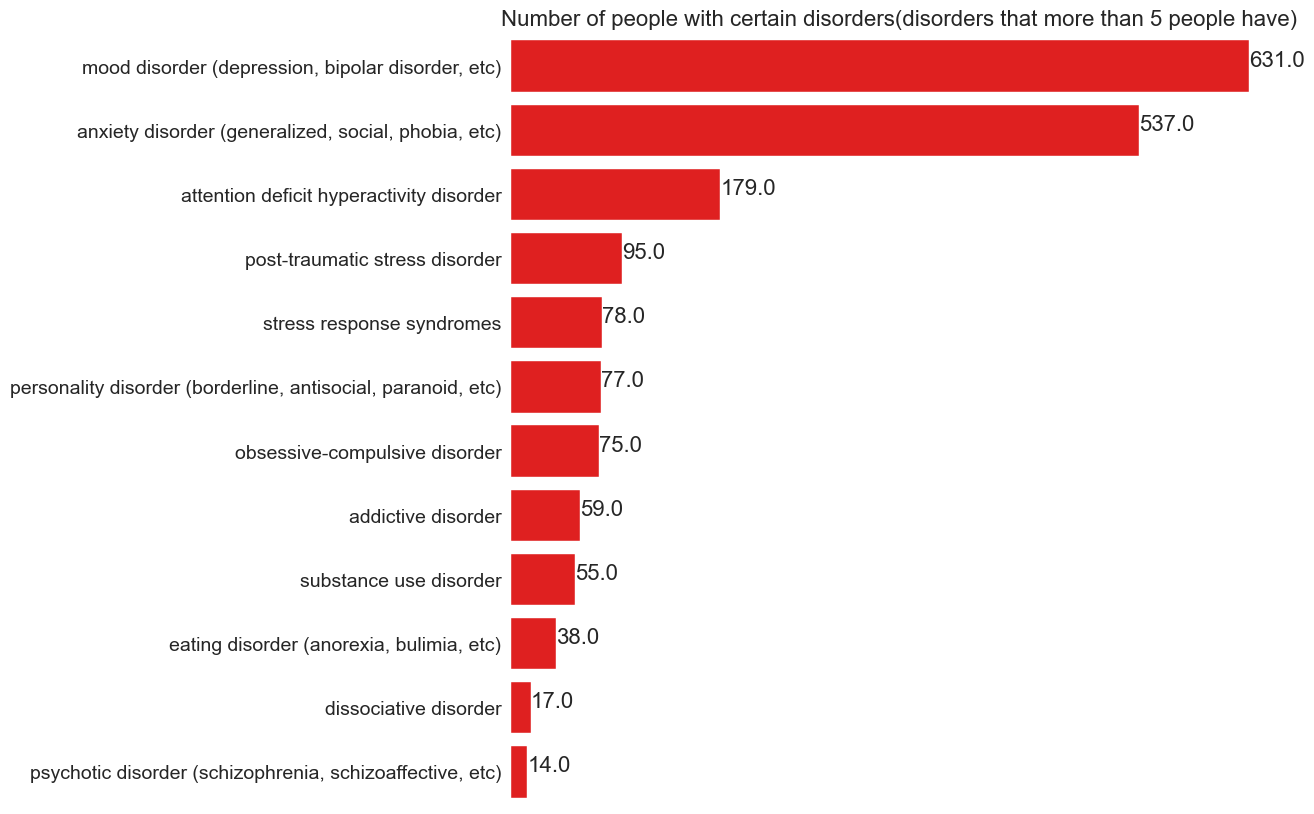

In [57]:
# count number of conditions 
conditions_count_q = '''
                        SELECT AnswerText Condition, COUNT(*) Occurences
                        FROM Answer
                        WHERE QuestionID IN (115, 116)
                        AND AnswerText <> '-1'
                        GROUP BY 1
                        ORDER BY 2 DESC
                        '''
conditions_count = pd.read_sql_query(conditions_count_q, conn)

# extract conditions which more than 5 people have
pop_conditions_count = conditions_count[conditions_count["Occurences"] > 5]

fig = plt.figure(figsize=(10, 10))
sns.barplot(x="Occurences", y="Condition", 
            data=pop_conditions_count, color="red")
plt.title("Number of people with certain disorders"
          "(disorders that more than 5 people have)", fontsize=16)
ax = plt.gca()
hf.customize_bar("h", ax, values_font=16)
ax.set_ylabel("")
ax.set_xlabel("")
plt.tick_params(axis='both', which='both', labelsize=14)
ax.get_ylabel()

Here is a bar plot of most popular mental disorders among our respondents. Mood and Anxiety disorders are the most prevalent ones

**Are certain disorders more prevalent among one gender compared to others?**

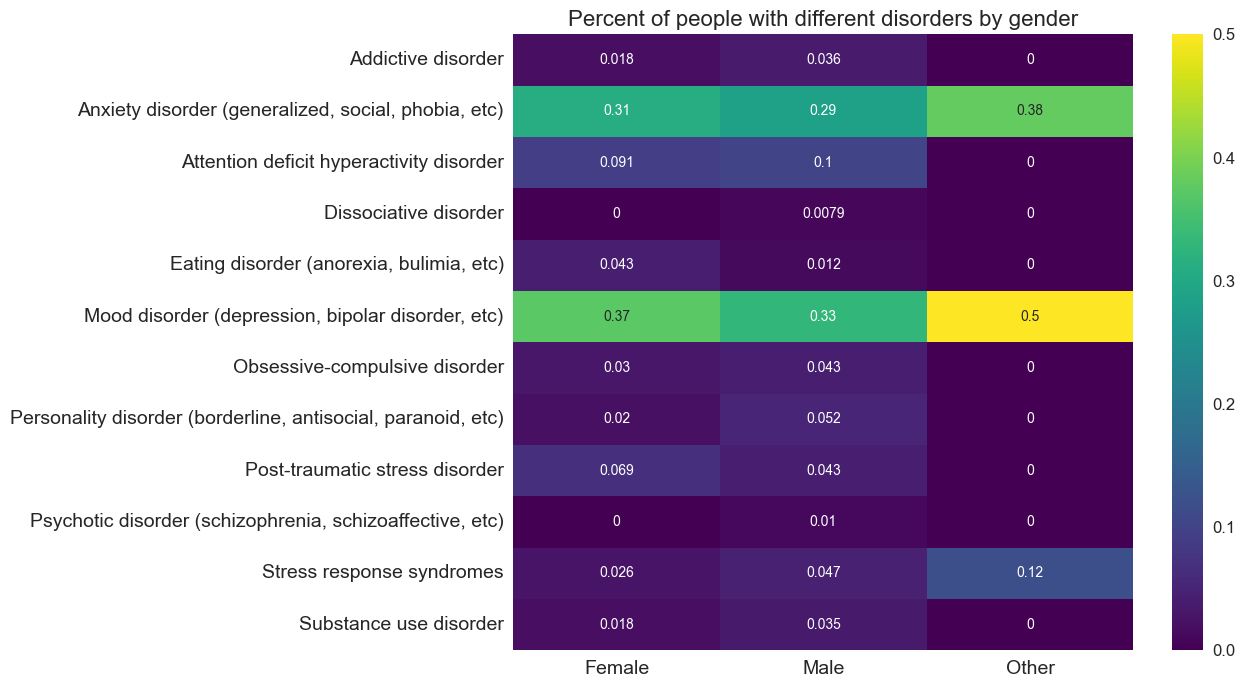

In [58]:
# count number of conditions for each year
gender_cond_count_q = '''
                        SELECT a1.AnswerText Gender, Condition, COUNT(*) count
                        FROM Answer a1
                        JOIN (SELECT AnswerText Condition, UserID
                              FROM Answer WHERE QuestionID IN (115, 116)
                              AND AnswerText <> '-1') 
                              a2 ON a2.UserID = a1.UserID
                        WHERE a1.questionID = 2
                        GROUP BY 1, 2
                        HAVING COUNT(*) > 5
                        '''
gender_cond_count = pd.read_sql_query(gender_cond_count_q, conn)

# pivot the table and count the percentages of each condition
# for each gender
gender_cond_count = (gender_cond_count
                     .pivot(index="Condition", 
                            values="count", 
                            columns="Gender").fillna(0))
gender_cond_count = gender_cond_count.apply(lambda x: x / x.sum())

# plot the heatmap
fig = plt.figure(figsize=(10, 8))
sns.heatmap(gender_cond_count, cmap='viridis', annot=True)
plt.title("Percent of people with different disorders by gender",
         fontsize=16)
ax = plt.gca()
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels(
    [label.get_text().capitalize() for label in ax.get_yticklabels()])
ax.set_xticklabels(["Female", "Male", "Other"])
plt.tick_params(axis='both', which='both', labelsize=14);

Examining the heatmap, the following observations emerges: individuals who don't identify strictly as male or female exhibit higher percentages of mood disorders (50%), stress response syndromes, and anxiety disorders. Furthermore, women stand out from other groups, displaying a higher tendency towards eating disorder, post-traumatic stress disorder. Whereas men have substance use disorder, personality disorder and stress response syndromes more.

**Do individuals diagnosed with various disorders have a family history of mental illness?**

In [59]:
# extract answers to the question:
# "Do you have a family history of mental disorders?"
fam_hist_q = '''
            SELECT AnswerText
            FROM Answer
            WHERE QuestionID = 6
            '''
pd.read_sql_query(fam_hist_q, conn)["AnswerText"].unique()

array(['no', 'yes', "i don't know"], dtype=object)

/var/folders/pl/3kzc8xg569bgwf57z74fn11w0000gn/T/ipykernel_40321/3375842741.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


Text(0.5, 0, 'Count')

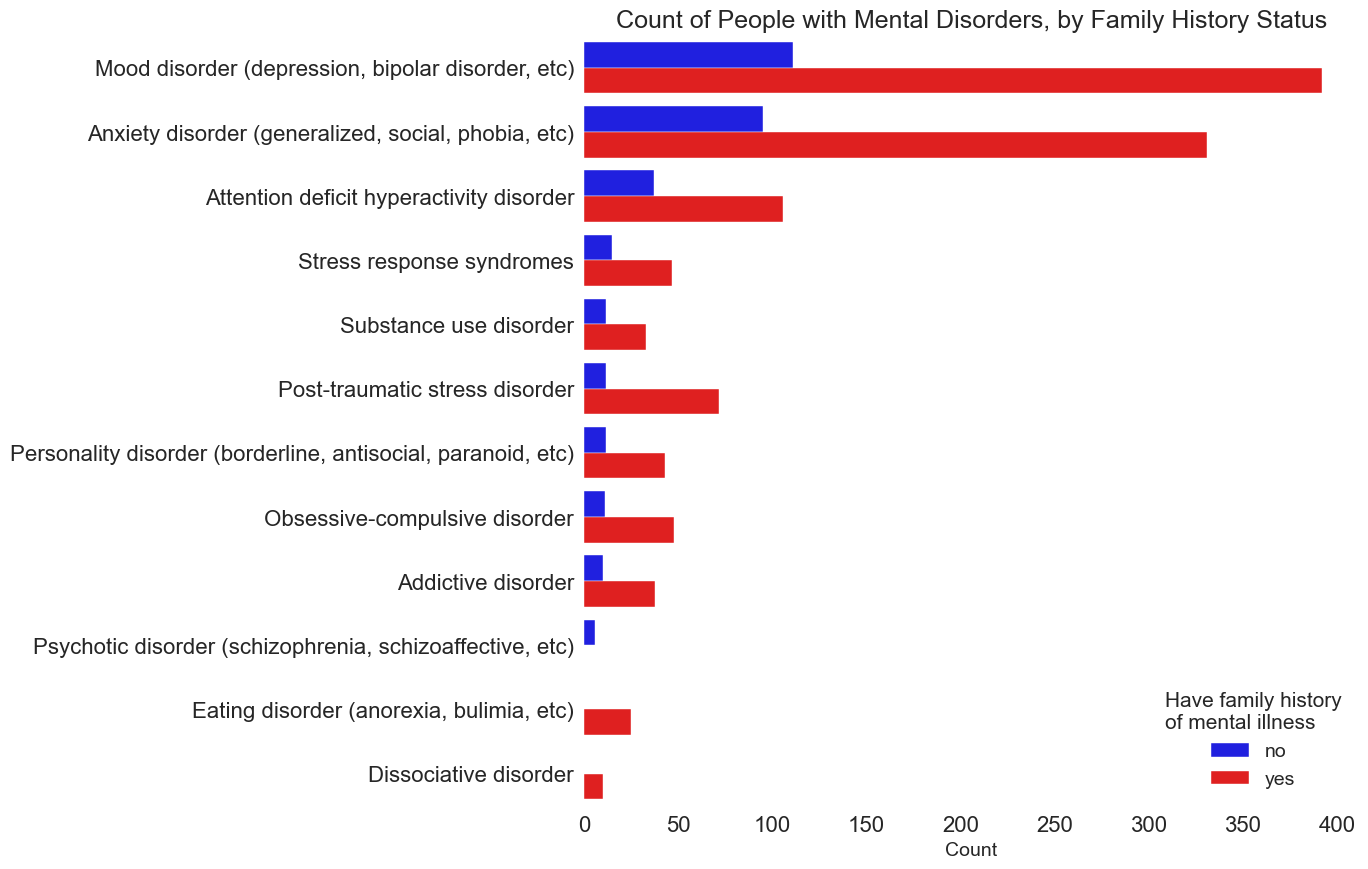

In [60]:
# for each condition count number number of people
# who had family history of disorder and those who didn't
cond_fam_hist_q = '''
                    SELECT a1.AnswerText FamilyMentalIllness, 
                    Condition, COUNT(*) count
                    FROM Answer a1
                    JOIN (SELECT AnswerText Condition, UserID
                          FROM Answer WHERE QuestionID IN (115, 116)
                          AND AnswerText <> '-1') 
                          a2 ON a2.UserID = a1.UserID
                    WHERE a1.questionID = 6
                    AND AnswerText IN ("yes", "no")
                    GROUP BY 1, 2
                    HAVING COUNT(*) > 5
                    ORDER BY 1, 3 DESC
                  '''
cond_fam_hist = pd.read_sql_query(cond_fam_hist_q, conn)

# plot the bar plots
fig = plt.figure(figsize=(10, 10))
sns.barplot(x='count', y='Condition', hue='FamilyMentalIllness',
           data=cond_fam_hist, palette=["blue", "red"])

plt.title("Count of People with Mental Disorders, by Family History Status",
         fontsize=18)
ax = plt.gca()
ax.set_yticklabels(
    [label.get_text().capitalize() for label in ax.get_yticklabels()])
sns.despine()
plt.legend(title="Have family history\n"
           "of mental illness", loc="best", fontsize=14, title_fontsize=15)
plt.ylabel("")
plt.tick_params(axis='both', which='both', labelsize=16)
plt.xlabel("Count", fontsize=14)

In different kinds of mental health problems, more people have relatives who also experienced mental illness compared to those who don't. This shows that family history plays a big role in mental health accross all most popular mental disorders.

**How are various mental conditions distributed among various age groups?**

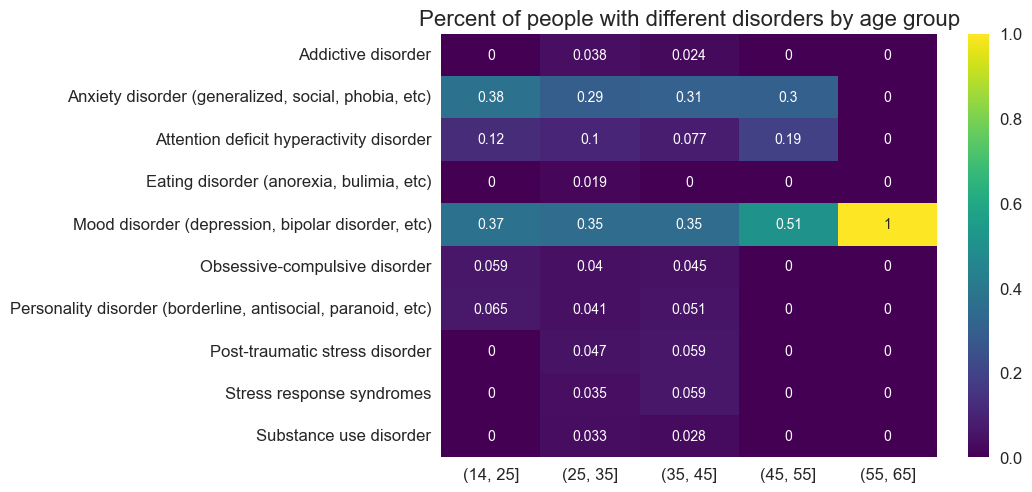

In [61]:
# count number of conditions for each year
age_condition_q = '''
    SELECT a1.AnswerText age, Condition
    FROM Answer a1
    JOIN (
            SELECT AnswerText Condition, UserID
            FROM Answer
            WHERE questionID IN (115, 116)
            AND AnswerText <> '-1'
            ) a2 ON a2.UserID = a1.UserID
    WHERE questionID = 1
    '''
age_condition = pd.read_sql_query(age_condition_q, conn)
age_condition["age"] = age_condition["age"].astype(int)

# create age group column for each age
age_condition["agegrp"] = (pd.cut(age_condition["age"],
                                       [14, 25, 35, 45, 55, 65, 75, 85, 100]))
# count number of people in each age group
age_condition = (age_condition
                    .groupby(['agegrp', "Condition"])
                 ["age"].count().reset_index())

age_condition = age_condition[age_condition["age"] > 10]
# pivot the table, count the percentage of those who have a
# disorder and those who don't in each agegroup
age_condition = (age_condition
                   .pivot(columns="agegrp", values="age", index="Condition")
                   .apply(lambda x: x / x.sum()))

age_condition = age_condition.fillna(0)
sns.heatmap(age_condition, cmap="viridis", annot=True)

plt.title("Percent of people with different disorders by age group",
         fontsize=16)
ax = plt.gca()
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels(
    [label.get_text().capitalize() for label in ax.get_yticklabels()]);

As individuals age, the prevalence of mood disorders tends to increase. In younger age groups, mood disorders, anxiety disorders, obsessive-compulsive disorders, and personality disorders are common. Addictive disorders, stress response syndromes, post-traumatic stress disorders are more prevalent in the age range of 25 to 45.

**How do mental characteristics vary among individuals in different job roles?**

In [62]:
# check answers to the question:
# "which of the following best describes your work position?"
work_position_q = '''
            SELECT AnswerText
            FROM Answer
            WHERE QuestionID = 117
            '''
pd.read_sql_query(work_position_q, conn)["AnswerText"].unique()

array(['back-end developer', 'front-end developer',
       'supervisor/team lead', 'executive leadership',
       'dev evangelist/advocate', 'devops/sysadmin', 'support',
       'designer', 'one-person shop', 'other', 'sales', 'hr'],
      dtype=object)

In [63]:
# count number of people with and without disorders
# for each work position
work_position_count_q = '''
            SELECT a1.AnswerText Position, a2.Disorder, COUNT(*) count
            FROM Answer a1
            JOIN (
                SELECT AnswerText Disorder, UserId FROM Answer
                WHERE QuestionID = 33
                    ) a2 ON a2.UserID = a1.UserId
            WHERE QuestionID = 117
            GROUP BY 1, 2
            '''
work_position_disorder = pd.read_sql_query(work_position_count_q, conn)

# pivot the table and count the percentages in each work position
work_position_disorder= (work_position_disorder
                         .pivot(columns="Disorder", 
                                values="count", index="Position")
                         .apply(lambda x: x / x.sum(), axis=1))

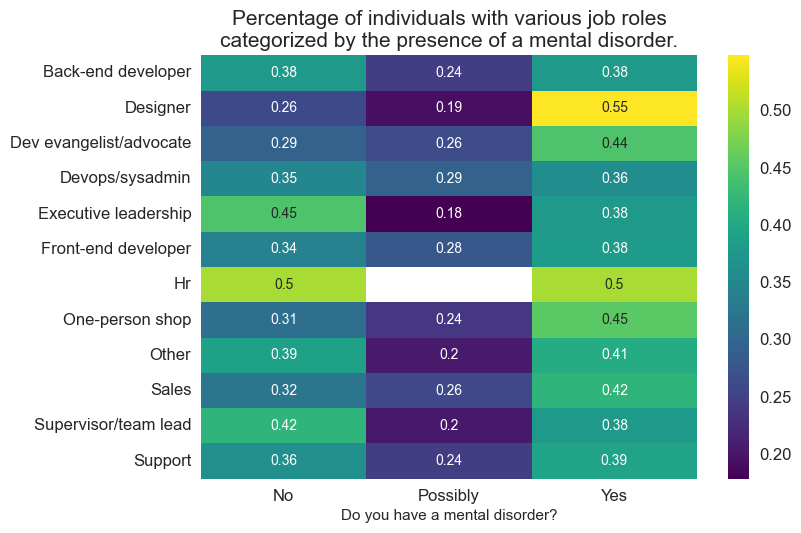

In [64]:
sns.heatmap(work_position_disorder, cmap='viridis', annot=True)
plt.title("Percentage of individuals with various job roles\n"
          "categorized by the presence of a mental disorder.",
         fontsize=15)
ax = plt.gca()
ax.set_ylabel("")
ax.set_xlabel("Do you have a mental disorder?")
ax.set_yticklabels(
    [label.get_text().capitalize() for label in ax.get_yticklabels()])
ax.set_xticklabels(["No", "Possibly", "Yes"]);

Among designers, the highest percentage of individuals with mental disorders is observed at 55%. Similarly, in the Human Resources field, there is an equal split between those with and without mental disorders, both at 50%. Individuals in top-level executive positions, supervisors/team leads exhibit the highest percentage of individuals without mental disorders.

**Does remote work impact individuals' mental well-being and contribute to an increase in mental health issues?**

In [65]:
# check answers to the question 
# "Do you work remotely?"
remote_work_q = '''
                SELECT AnswerText WorkRemotely
                FROM Answer
                WHERE QuestionID = 118
                '''
pd.read_sql_query(remote_work_q, conn)["WorkRemotely"].unique()

array(['sometimes', 'never', 'always'], dtype=object)

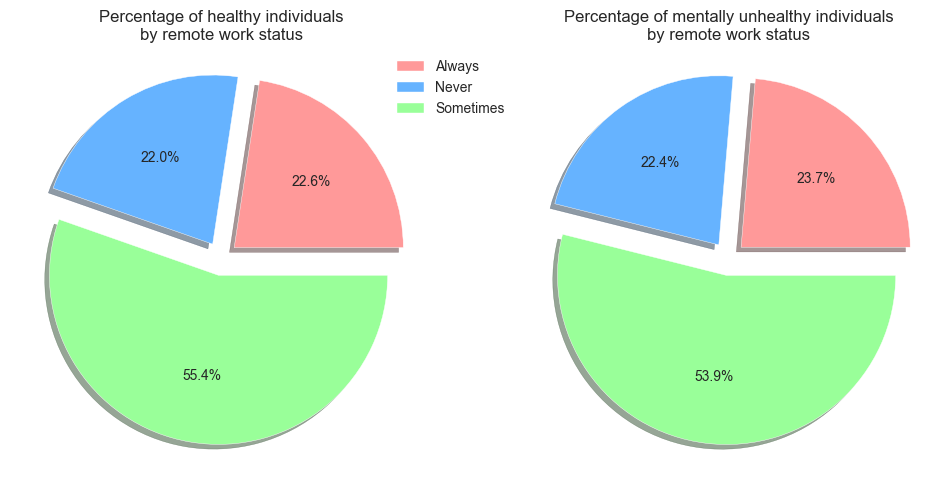

In [66]:
# for answers about the remote work
# count how many people have disorder
rw_disorder_q = '''
                SELECT a1.AnswerText WorkRemotely, a2.Disorder, 
                COUNT(*) count
                FROM Answer a1
                JOIN (
                    SELECT AnswerText Disorder, UserId FROM Answer
                    WHERE QuestionID = 33
                    AND AnswerText <> "possibly"
                        ) a2 ON a2.UserID = a1.UserId
                WHERE QuestionID = 118
                GROUP BY 1, 2
                '''
rw_disorder = pd.read_sql_query(rw_disorder_q, conn)

# plot two pie plots(for those who have a disorder and don't)
# of percentage of people who always, sometimes or never work remotely
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
i = 0
for option, group in rw_disorder.groupby("Disorder"):
    plt.sca(ax[i])
    ax[i].set_title(option)
    plt.pie(group["count"], colors=['#ff9999', '#66b3ff', '#99ff99'],
            shadow=True, explode=(0.1, 0.1, 0.1), autopct='%1.1f%%')
    i+=1
ax[0].set_title("Percentage of healthy individuals\n"
                "by remote work status")
ax[1].set_title("Percentage of mentally unhealthy individuals\n"
                "by remote work status")
plt.legend(labels=["Always", "Never", "Sometimes"], bbox_to_anchor=(0, 1));

Looking at this graph, it seems that there's no variation in mental health between people who work from home and those who work in an office.

**Are there differences in the types of mental health issues experienced by individuals who work remotely compared to those who do not?**

In [67]:
q = '''
     SELECT AnswerText Condition
    FROM Answer
    WHERE QuestionID IN (115, 116)
    '''
pd.read_sql_query(q, conn)

,Condition
0,-1
1,"anxiety disorder (generalized, social, phobia,..."
2,"mood disorder (depression, bipolar disorder, etc)"
3,-1
4,"anxiety disorder (generalized, social, phobia,..."
...,...
3860,-1
3861,"anxiety disorder (generalized, social, phobia,..."
3862,"mood disorder (depression, bipolar disorder, etc)"
3863,-1


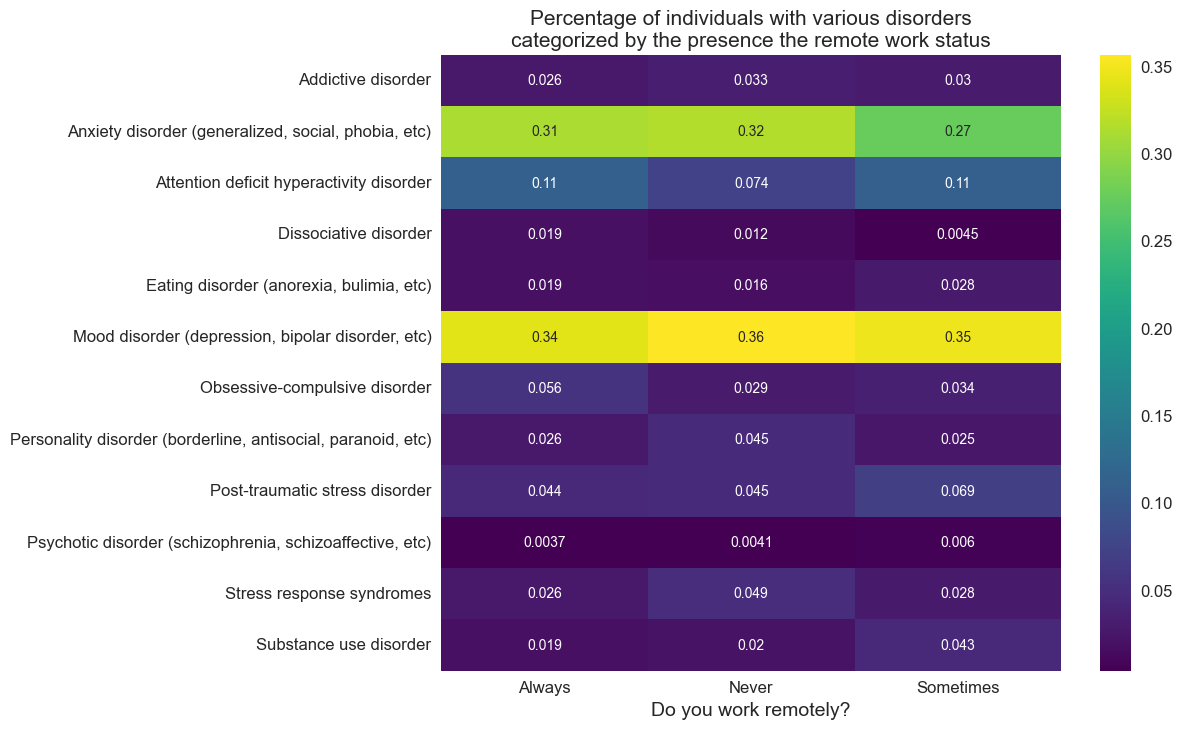

In [68]:
# for conditions that more than 10 people have
# count people based on their answer to the 
# question about remote work
rw_condition_q = '''
                SELECT AnswerText Condition, WorkRemotely, 
                COUNT(*) count
                FROM Answer a1 
                JOIN (
                    SELECT AnswerText Condition, COUNT(*) condition_count
                    FROM Answer 
                    WHERE QuestionID IN (115, 116)
                    AND AnswerText <> '-1'
                    GROUP BY 1
                    HAVING COUNT(*) > 10
                    ) a2 ON a2.Condition = a1.AnswerText
                JOIN (
                    SELECT AnswerText WorkRemotely, UserId FROM Answer
                    WHERE QuestionID = 118
                        ) a3 ON a3.UserID = a1.UserId
                WHERE QuestionID IN (115)
                AND AnswerText <> '-1'
                GROUP BY 1, 2
    '''
rw_condition = pd.read_sql_query(rw_condition_q, conn)

# pivot the table to count the percentages of each condition in
# each group of remote work
rw_condition = rw_condition.pivot(columns="WorkRemotely", 
                                  values='count',
                                  index='Condition').apply(lambda x: x/x.sum())
fig = plt.figure(figsize=(10, 8))
sns.heatmap(rw_condition, annot=True, cmap='viridis')
plt.title("Percentage of individuals with various disorders\n"
          "categorized by the presence the remote work status",
         fontsize=15)
ax = plt.gca()
ax.set_ylabel("")
ax.set_xlabel("Do you work remotely?", fontsize=14)
ax.set_xticklabels(["Always", "Never", "Sometimes"])
ax.set_yticklabels(
    [label.get_text().capitalize() for label in ax.get_yticklabels()]);

We don't see any variation in the percentage of mental health disorders among different groups of people based on their responses regarding remote work.

**Regarding employment status, is there a distinction in mental health between those who are self-employed and those who are not?**

In [69]:
# check answers to the question:
# "Are you self-employed?"
employment_q = '''
                SELECT AnswerText Self_Employed
                FROM Answer
                WHERE QuestionID = 5
                GROUP BY 1
                '''
pd.read_sql_query(employment_q, conn)["Self_Employed"].unique()

array(['-1', '0', '1'], dtype=object)

In [70]:
# count number of people for each gender, employment type
# and whether there is a disorder
emp_gend_dis_q = '''
                SELECT a1.AnswerText SelfEmployed, 
                a2.Disorder, Gender, count(*) count
                FROM Answer a1
                JOIN (
                    SELECT AnswerText Disorder, UserId FROM Answer
                    WHERE QuestionID = 33
                    AND AnswerText not in ('possibly', "don't know", "-1")
                        ) a2 ON a2.UserID = a1.UserId
                JOIN (
                    SELECT AnswerText Gender, UserId FROM Answer
                    WHERE QuestionID = 2
                        ) a3 ON a3.UserID = a1.UserId
                WHERE a1.QuestionID = 5
                GROUP BY 1, 2, 3
                '''
have_disorder_employed = pd.read_sql_query(emp_gend_dis_q, conn)

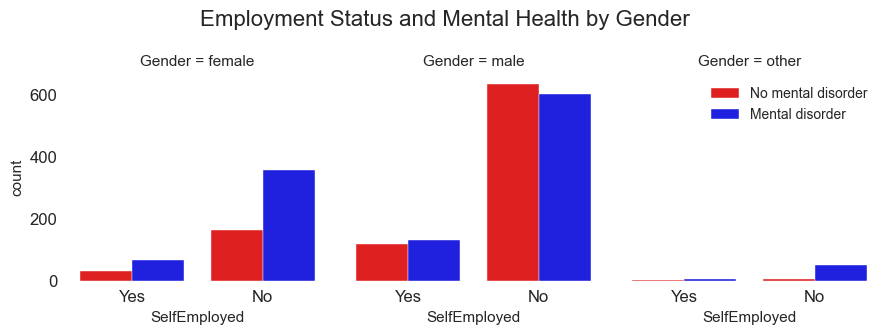

In [71]:
# plot a bar plots for each gender:
# number of people with disorders depending on whether
# they are self-employed
fac_grid = sns.FacetGrid(have_disorder_employed, col='Gender')
fac_grid.map_dataframe(sns.barplot, "SelfEmployed", 
                       "count", order=['1', '0'],  hue="Disorder",
                       palette=["red", "blue"])
fac_grid.set_xticklabels(["Yes", "No"])
ax = plt.gca()
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["No mental disorder", "Mental disorder"])
plt.suptitle('Employment Status and Mental Health by Gender', x=0.5,
            y=1.1, fontsize=16);

In both self-employed and non-self-employed females, there's a higher prevalence of individuals with disorders. For males, the occurrence of disorders is relatively balanced regardless of self-employment status. Similarly, in the other group, there's a greater number of individuals with disorders in both categories.

**Are there particular conditions that are more common among self-employed individuals?**

In [72]:
# for conditions that more than 10 people have
# count people based on their answer to the 
# question about self-employment
condition_employment_q = '''
                        SELECT AnswerText Condition,
                        SelfEmployed, COUNT(*) count
                        FROM Answer a1 
                        JOIN (
                            SELECT AnswerText Condition, 
                            COUNT(*) condition_count
                            FROM Answer 
                            WHERE QuestionID IN (115, 116)
                            AND AnswerText <> '-1'
                            GROUP BY 1
                            HAVING COUNT(*) > 10
                            ) a2 ON a2.Condition = a1.AnswerText
                        JOIN (
                            SELECT AnswerText SelfEmployed, UserId FROM Answer
                            WHERE QuestionID = 5
                                ) a3 ON a3.UserID = a1.UserId
                        WHERE QuestionID IN (115, 116)
                        AND AnswerText <> '-1'
                        GROUP BY 1, 2
                        '''
condition_employment = pd.read_sql_query(condition_employment_q, conn)

# pivot the table to count the percentages
condition_employment = (condition_employment
                        .pivot(columns="SelfEmployed",
                               values='count',
                               index='Condition')
                        .apply(lambda x: x / x.sum()))

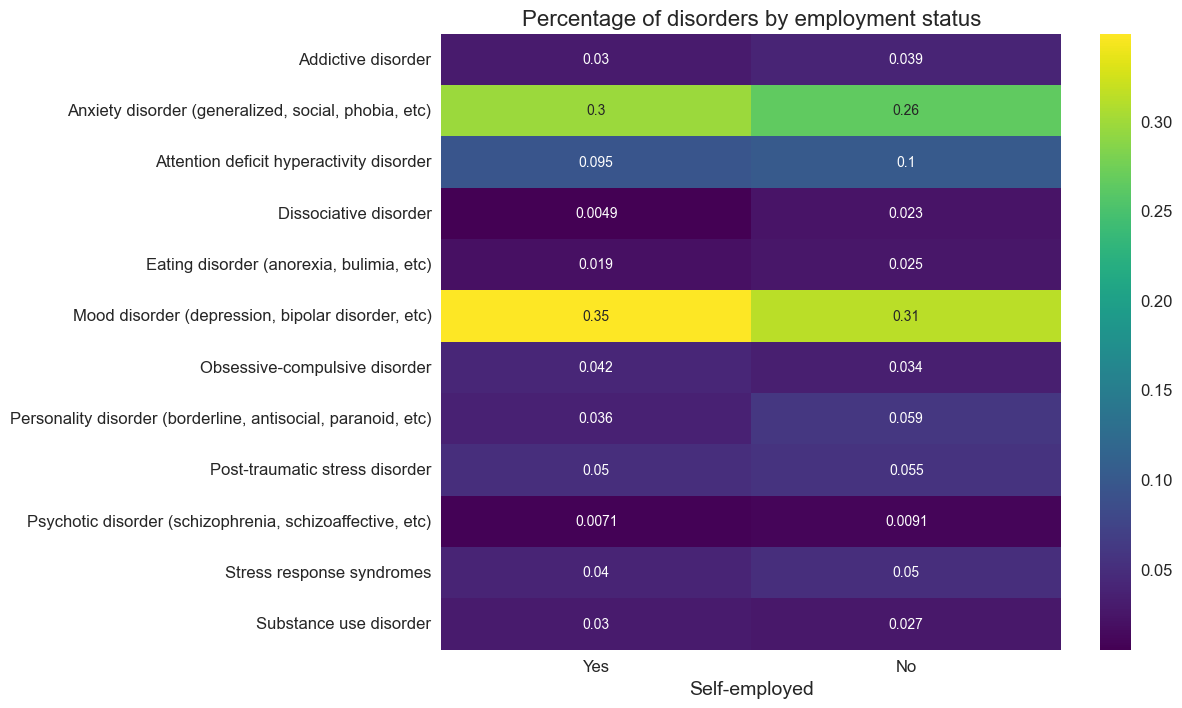

In [73]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(condition_employment, 
            annot=True, cmap='viridis')

plt.title("Percentage of disorders by employment status", fontsize=16)
ax = plt.gca()
ax.set_xlabel("Self-employed", fontsize=14)
ax.set_yticklabels(
    [label.get_text().capitalize() for label in ax.get_yticklabels()])
ax.set_xticklabels(["Yes", "No"])
ax.set_ylabel("");

Among the people who are self-employed the percent of those with mood or anxiety disorder is slightly higher

**What is the distribution of our respondents across different sizes of companies?**

In [74]:
# check answers to the question about the size of the company
employees_number_q = """
                    SELECT AnswerText Size
                    FROM Answer
                    WHERE QuestionID = 8
                    """
pd.read_sql_query(employees_number_q, conn)["Size"].unique()

array(['6-25', 'more than 1000', '26-100', '100-500', '1-5', '500-1000',
       '-1'], dtype=object)

In [75]:
# count number of people for each company size
employees_number = """
                    SELECT AnswerText CompanySize, COUNT(*) count
                    FROM Answer
                    WHERE QuestionID = 8
                    AND AnswerText != "-1"
                    GROUP BY 1
                    """
employees_number = pd.read_sql_query(employees_number, conn)
employees_number

,CompanySize,count
0,1-5,254
1,100-500,788
2,26-100,824
3,500-1000,247
4,6-25,689
5,more than 1000,912


In [76]:
# covert "CompanySize" to the ordered categorical variable
order = ["1-5", "6-25", "26-100", "100-500", "500-1000", "more than 1000"]
employees_number['CompanySize'] = (pd.Categorical(
    employees_number['CompanySize'], categories=order, ordered=True))

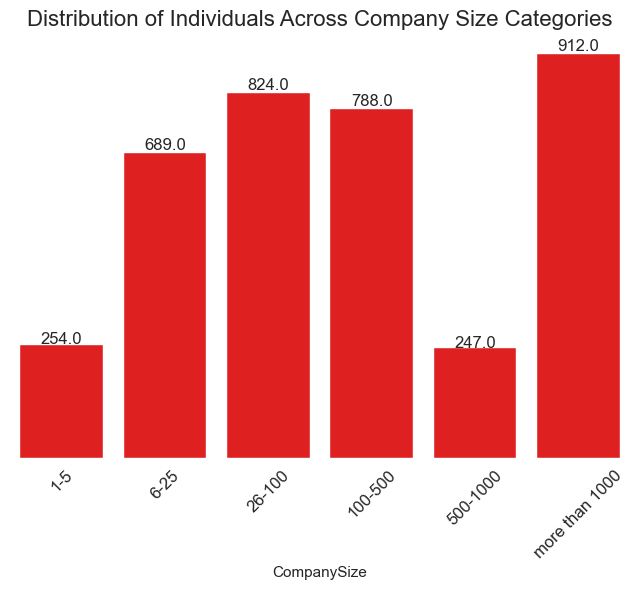

In [77]:
sns.barplot(x="CompanySize", y="count", data=employees_number, color="red")
ax = plt.gca()
hf.customize_bar("v", ax)
ax.set_ylabel("")
plt.xticks(rotation=45)
plt.title("Distribution of Individuals Across Company Size Categories",
         fontsize=16);

**Among different company sizes, which ones offer mental health benefits as part of their healthcare coverage?**

In [78]:
# check answers to the question:
# "does your employer provide mental 
# health benefits as part of healthcare coverage?"
coverage_q = """
            SELECT AnswerText Coverage
            FROM Answer
            WHERE QuestionID = 10
            """
pd.read_sql_query(coverage_q, conn)["Coverage"].unique()

array(['yes', "don't know", 'no', 'not eligible for coverage / na', '-1',
       "i don't know"], dtype=object)

In [79]:
# for each company size count number of companies which
# provide mental coverage and which don't
size_coverage_q = """
                    SELECT a1.AnswerText Size, a2.ProvidesCoverage, 
                    COUNT(*) count
                    FROM Answer a1
                    JOIN (
                        SELECT AnswerText ProvidesCoverage, UserID
                        FROM Answer
                        WHERE QuestionID = 10
                        AND AnswerText IN ('yes', 'no')
                        ) a2 ON a2.UserID = a1.UserID
                    WHERE QuestionID = 8
                    GROUP BY 1, 2
                    """
size_coverage = pd.read_sql_query(size_coverage_q, conn)

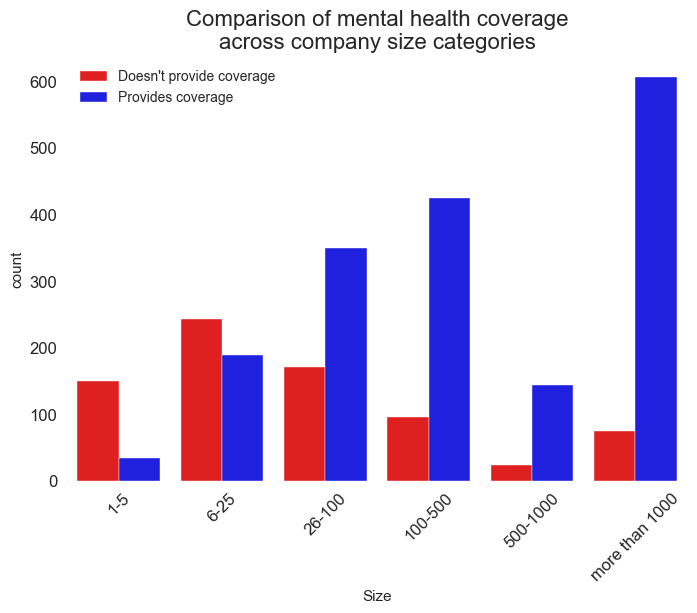

In [80]:
sns.barplot(x="Size", y="count", hue="ProvidesCoverage", data=size_coverage,
           order=order, palette={"yes": "blue", "no": "red"})
sns.despine(bottom=True)
plt.title("Comparison of mental health coverage\n"
          "across company size categories", fontsize=16)
ax = plt.gca()
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ["Doesn't provide coverage", "Provides coverage"],
           loc="upper left")
plt.xticks(rotation=45);

Smaller companies provide less health coverage than bigger

**How does the percentage of individuals with mental health disorders vary across different company sizes?**

In [81]:
# for each company size, count number of people who
# have and don't have disorders
size_disorder_q = '''
    SELECT Size, a1.AnswerText HaveDisorder, COUNT(*) count
    FROM Answer a1
    JOIN (
        SELECT AnswerText Size, UserID
        FROM Answer
        WHERE QuestionID = 8
        AND AnswerText <> '-1'
        ) a2 ON a2.UserID = a1.UserID 
    WHERE QuestionID = 33
    AND AnswerText IN ('yes', 'no')
    GROUP BY 1, 2
    '''
size_disorder = pd.read_sql_query(size_disorder_q, conn)

In [82]:
# calculate percentage of people with and witout mental health disorders
# in each company size
size_disorder = (size_disorder
                 .pivot(columns="HaveDisorder", 
                        values="count", index="Size")
                 .apply(lambda x: x / x.sum(), axis=1).reset_index())
size_disorder = (size_disorder
                    .melt(id_vars='Size', 
                          var_name='HaveDisorder', 
                          value_name='Percentage'))

# keep only percentages of people who have disorders
size_disorder = size_disorder[size_disorder["HaveDisorder"] == "yes"]
# for plotting, set the "Size" column to categorical type
size_disorder['Size'] = (pd.Categorical(
    size_disorder['Size'], categories=order, ordered=True))

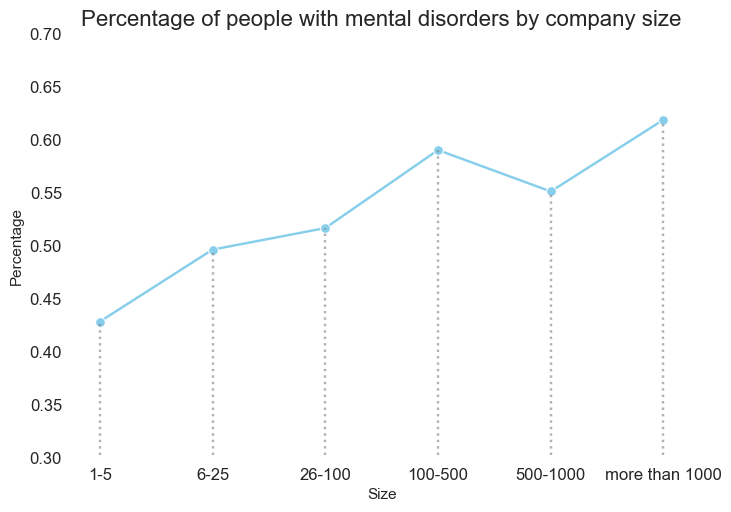

In [83]:
sns.lineplot(x="Size", y="Percentage", data=size_disorder, 
             marker='o', color='skyblue')
for x, y in zip(size_disorder['Size'], size_disorder["Percentage"]):
    plt.vlines(x, ymin=0, ymax=y, colors='gray', 
               linestyles='dotted', alpha=0.6)
plt.ylim(0.3, 0.7)
plt.title("Percentage of people with mental disorders by company size",
         fontsize=16);

The availability of mental health coverage for employees seems to vary with the size of the company. Smaller companies, with fewer employees, may less frequently offer mental health coverage compared to larger corporations. However, this disparity doesn't necessarily correlate with a higher prevalence of mental health issues among employees in smaller companies. Surprisingly, smaller companies exhibit a higher percentage of healthy respondents compared to larger corporations. This suggests that the size of the company may indeed play a significant role in the mental well-being of employees, with smaller organizations potentially fostering a healthier work environment.

**Among companies of varying sizes, who prioritizes both physical and mental health?**

Check answers to questions:
   * How much importance does your employee place on your physical health?
   * How much importance does your employee place on your mental health?

In [84]:
mental_imp_q = """
        SELECT AnswerText MentalImportance, UserID
        FROM Answer
        WHERE QuestionID = 65
    """
pd.read_sql_query(mental_imp_q, conn)["MentalImportance"].unique()

array(['0', '2', '1', '5', '-1', '10', '8', '7', '3', '9', '6', '4'],
      dtype=object)

In [85]:
physical_imp_q = """
            SELECT AnswerText PhysicalImportance, UserID
            FROM Answer
            WHERE QuestionID = 64
        """
pd.read_sql_query(physical_imp_q, conn)["PhysicalImportance"].unique()

array(['6', '7', '0', '-1', '9', '10', '1', '5', '3', '8', '4', '2'],
      dtype=object)

Plot Lineplots for two questions:

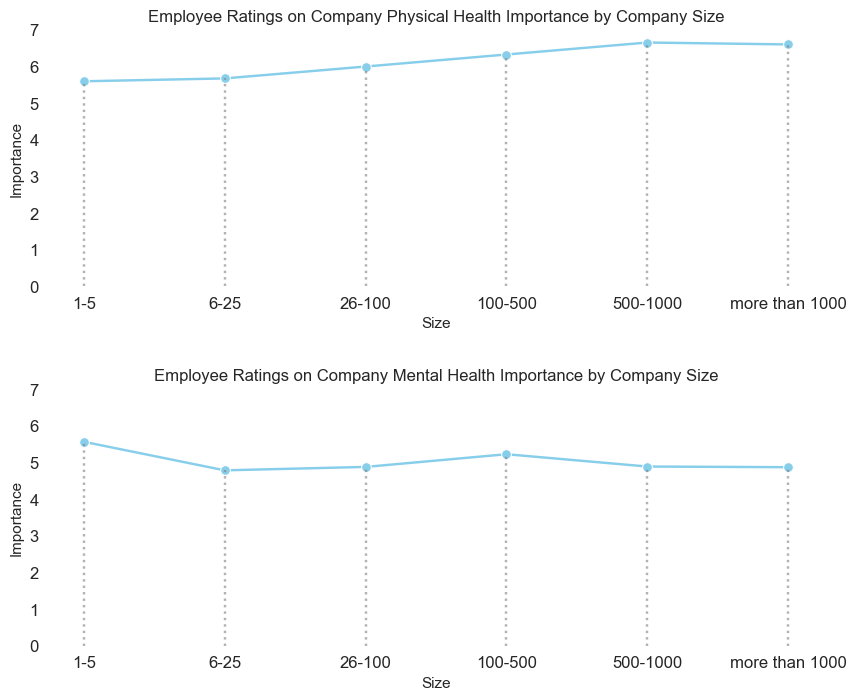

In [86]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)
for i, question_id in enumerate((64, 65)):
    # for each company size and importance(1 to 10)
    # count number of people
    size_imp_q = """
                SELECT a1.AnswerText Size, a2.Importance
                FROM Answer a1
                JOIN (
                    SELECT AnswerText Importance, UserID
                    FROM Answer
                    WHERE QuestionID = ?
                    AND AnswerText != -1
                    ) a2 ON a2.UserID = a1.UserID
                WHERE QuestionID = 8
                """
    size_imp = pd.read_sql_query(size_imp_q, conn, params=(question_id, ))

    # turn "Importance" to int type for plotting
    size_imp["Importance"] = size_imp["Importance"].astype(int)
    
    # calculate average Importance rating
    size_mean_imp = size_imp.groupby("Size")["Importance"].mean().reset_index()
    
    # convert "Size" column to a categorical type for plotting
    size_mean_imp['Size'] = (pd.Categorical(
        size_mean_imp['Size'], categories=order, ordered=True))
    # create a lineplot
    sns.lineplot(ax=ax[i], x="Size", y="Importance", data=size_mean_imp,
                 marker='o', color='skyblue')
    for x, y in zip(size_mean_imp['Size'], size_mean_imp["Importance"]):
        ax[i].vlines(x, ymin=0, ymax=y, 
                     colors='gray', linestyles='dotted', alpha=0.6)
ax[0].set_ylim(0, 7)
ax[0].set_title("Employee Ratings on Company Physical Health "
                "Importance by Company Size")

ax[1].set_ylim(0, 7)
ax[1].set_title("Employee Ratings on Company Mental Health "
                "Importance by Company Size");

Larger companies prioritize the physical health of their employees more than smaller ones do. There is no consistent trend regarding the importance placed on mental health. However, we can see that the smallest type of companies on average put more importance on the mental health of their employees.

### Conclusion of our exploratory data analysis:
A lot of the respondents have problems with their mental health. There are some variations in mental health experiences based on gender. Women and individuals who identify outside the traditional binary genders tend to report higher percentages of mental health issues compared to men. Additionally, women exhibit a higher tendency towards specific disorders like eating disorders and post-traumatic stress disorder, whereas men show higher prevalence rates of substance use disorders, personality disorder, and stress response syndromes. Moreover, men are less likely to seek help for their mental health issues compared to other groups.

Age plays some role in mental health outcomes, with the prevalence of mood disorders increasing as individuals age. Younger age groups tend to experience mood disorders, anxiety disorders, obsessive-compulsive disorders, and personality disorders frequently. On the other hand, addictive disorders, stress response syndromes, post-traumatic stress disorders are more prevalent among individuals aged 25 to 45.

The analysis reveals significant variations in mental health outcomes based on job roles. Designers and people working in the Human Resources field exhibit a high prevalence of mental disorders, while top-level executives and supervisors report the lowest occurrence. Interestingly, remote and office workers show no difference in mental health outcomes, indicating that work environment might not be a significant factor in this regard.

The data suggests that company size influences the availability of mental health coverage, with smaller companies offering less coverage compared to larger corporations. Despite this, smaller companies have a higher percentage of healthy employees, potentially indicating a more supportive work environment. We have found that larger companies prioritize physical health more than smaller ones. The smallest type of companies put the most importance on mental health of their employees.

Considering these findings, here are some recommendation on imporving mental health of people working in the Tech industry:
   * Develop more mental heatlh initiatives that help people to combat their mental health issues. Consider that women and people who identify themselfes outside of traditional binary gender are at the highest risk of having mental problems. In addition, there should be focus on helping men be more open about their problems. 
   * Mood and anxiety disorders are the most prevalent types of disorders. Therefore, it would be useful to create some programs focusing on overcoming these problems. Consider that more old people, people who don't identify themselves as men or women are succinct to have mood disorders. Younger people have anxiety disorders more often.
   *  Provide more mental health support for jobs which are more susceptibe to have mental problems: designers and people in Human Resources
   * In companies, put more importance on the health of the employees, both physical and mental. Especially for larger companies, it is important to create more friendly environment among their employees

### Suggestions on imporving the analysis:
   * Exploring different types of companies' policies on employees' mental health could help to understand more what type of treatment to employees improves their mental health
   * Getting data on the years after 2019 would make our analyis more precise. Especially, we could find out how people's health was affected by the Covid and world problems
   * Examining how the productivity of the surveyed participants is affected by their mental problems. The results could be the motivation for companies to improve mental treatment of their employees.